<div style="background-color: #EEEFFF; padding: 10px;">
\begin{align*}
    \Large{(2025)}
\end{align*}

\begin{align*}
    \Large{Information\hspace{0.3cm} Fusion}
 \end{align*}

\begin{align*}
    \Large{Fusion-Enhanced\hspace{0.3cm} Multi-Label  \hspace{0.3cm}Feature \hspace{0.3cm} Selection  \hspace{0.3cm} With  \hspace{0.3cm} Sparse  \hspace{0.3cm}Supplementation}
\end{align*}

\begin{align*}
    \Large{\min_W\lVert \textbf{XW} - \textbf{Y} \lVert} + \alpha \mathrm{Tr}(\textbf{WLW}^\top) + \beta\lVert\textbf{W}\lVert_{2,1} + \gamma(\lVert \textbf{WW}^\top\lVert_1 - \lVert \textbf{W} \lVert^2_F)  \quad\quad {\text{s.t.}\quad} \textbf{W}\geq 0
\end{align*}





$ $

In [1]:
import os
import torch
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from sklearn.cluster import KMeans
from skmultilearn.adapt import MLkNN
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import label_ranking_loss
from sklearn.metrics import hamming_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import coverage_error
from sklearn.metrics import zero_one_loss
import sklearn
from numpy.matlib import repmat
import pandas as pd
import warnings
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
warnings.filterwarnings('ignore')

In [2]:
## GPU or CPU

GPU = False
if GPU:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs", torch.cuda.device_count())
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    print("CPU")
    

CPU


In [3]:
def corr(Y):
    C = sklearn.metrics.pairwise.cosine_similarity(Y.T)
    Dc = np.diag(np.sum(C, axis=1))
    
    return C, Dc


 MLkNN Classifier:

 Micro-F1: 0.3126222355950053 
 Macro-F1: 0.15221819996401031 
 Average Precision: 0.33971767546579673 
 Hamming Loss: 0.058576923076923075 
 Ranking Loss: 0.219754663520228 
 Zero-One Loss: 0.8003333333333333 
 Coverage Error: 8.298333333333334

 SVM Classifier:

 Micro-F1: 0.3198599618077657 
 Macro-F1: 0.14176939705511035 
 Hamming Loss: 0.054794871794871795 
 Zero-One Loss: 0.8113333333333334


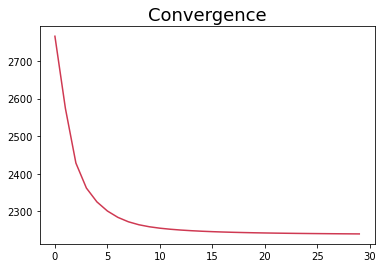

In [4]:

datasetML = ['Arts','Science','Entertainment','Health','Recreation' ,'Reference','Social','Society','Corel5k','Business','Education']

for db in range(0,1):
    
    dataset_name = Path(f'{datasetML[db]}').stem
    data = loadmat(f'../../datasets/{datasetML[db]}')
    train = data['train']
    test = data['test']

    X_test = train[0][0].T
    Y_test = train[0][1].T
    Y_test[Y_test == -1] = 0

    X = torch.from_numpy(test[0][0].T).type(dtype)

    Y = torch.from_numpy(test[0][1].T).type(dtype)
    Y[Y == -1] = 0

    Ycn = Y.cpu().numpy()
    Xc = test[0][0].T

    #Feature
    n,d = X.shape
    #label
    n,l = Y.shape

    #label correlation
    epsilon = torch.tensor(torch.finfo(torch.float32).eps)
    
    #cosine simmilarity :
    S,A = corr(Y)
    L = A-S

#     alpha  = [0.01,0.1,0.3,0.5,0.7,0.9,1]
#     beta   = [0.01,0.1,0.3,0.5,0.7,0.9,1]
#     gamma  = [0.01,0.1,0.3,0.5,0.7,0.9,1]

    alpha = [0.1]
    beta  = [0.1]
    gamma = [0.1]

    t=30
    for a in alpha:
        for b in beta:
            for g in gamma:
                erro= torch.zeros(t)
                for avg in range(1):
                    dd =torch.ones((d,d))
                    W = torch.rand(d,l)
                    for i in range(t):
                        D  = torch.diag(1 / (2 * torch.norm(W, dim=1) + epsilon))
                        Up = (X.T @ Y + a * (W @ S) + g * (W))
                        Dw = (X.T @ X @ W + a * ( W @ A) + b * (D @ W) + g * (dd @ W))
                        W  = W * (Up / torch.maximum(Dw , epsilon))

                        T1 = torch.norm(X @ W - Y) ** 2
                        T2 = a * (torch.trace(W @ (1-S) @ W.T))
                        T3 = b  * (torch.sum(torch.norm(W, dim=1)))
                        T4 = g * (torch.sum(torch.abs(W.T @ W)) - torch.norm(W)**2)
                        erro[i] = T1 + T2 + T3 + T4 

                    plt.title('Convergence', fontsize=18)
                    plt.plot(erro[:],color="#cf3952")
                    WW = torch.norm(W, dim=1, p=2)
                    sQ = torch.argsort(WW)
                    sQ = sQ.cpu()

                    nosf = int (20 * d / 100)
                    sX = X[:,sQ[d-nosf:]]
                    
                    classifier = MLkNN(k=10)
                    classifier.fit(sX, Ycn.astype(int))
                    # predict
                    predictions = classifier.predict(X_test[:,sQ[d-nosf:].long()]).toarray()
                    scores = classifier.predict_proba(X_test[:,sQ[d-nosf:].long()]).toarray()
                    MIC = f1_score(Y_test, predictions, average='micro')
                    MAC = f1_score(Y_test, predictions, average='macro')
                    AVP = average_precision_score(Y_test.T,scores.T)
                    HML = hamming_loss(Y_test,predictions)
                    RNL = label_ranking_loss(Y_test,scores)
                    ZER = zero_one_loss(Y_test,predictions)
                    CVE = coverage_error(Y_test,scores)
                    print('\n','MLkNN Classifier:')
                    print('\n','Micro-F1:',MIC,'\n','Macro-F1:',MAC,'\n','Average Precision:',AVP,'\n','Hamming Loss:',HML,'\n','Ranking Loss:',RNL,'\n','Zero-One Loss:',ZER,'\n','Coverage Error:',CVE)
                    
                    #SVM
                    classifiervm = OneVsRestClassifier(LinearSVC())
                    classifiervm.fit(sX, Ycn.astype(int))
                    predictionsvm = classifiervm.predict(X_test[:,sQ[d-nosf:].long()])
                    MICvm = f1_score(Y_test, predictionsvm, average='micro')
                    MACvm = f1_score(Y_test, predictionsvm, average='macro')
                    HMLvm = hamming_loss(Y_test,predictionsvm)
                    ZERvm = zero_one_loss(Y_test,predictionsvm)
                    print('\n','SVM Classifier:')
                    print('\n','Micro-F1:',MICvm,'\n','Macro-F1:',MACvm,'\n','Hamming Loss:',HMLvm,'\n','Zero-One Loss:',ZERvm)
                    